<a href="https://colab.research.google.com/github/CheilaBaiao/GEE_SR/blob/main/2)fogo_dnbr_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title F1-1 — Setup (robusta: cria config.yaml se não existir)
%pip -q install numpy rasterio rioxarray xarray tqdm pyyaml

import glob, json, yaml, os
import numpy as np
from pathlib import Path
import rasterio as rio
from tqdm.notebook import tqdm

from google.colab import drive
drive.mount('/content/drive')




# Pastas (iguais ao NB1)
BASE_DIR = Path("/content/drive/MyDrive/Pantanal_TippingPoints/index")
INT_DIR  = BASE_DIR / "interim"
OUT_DIR  = BASE_DIR / "outputs"
LOG_DIR  = BASE_DIR / "logs"
for d in (BASE_DIR, INT_DIR, OUT_DIR, LOG_DIR): d.mkdir(parents=True, exist_ok=True)
EV_DIR = OUT_DIR / "fase1_events_300m"
EV_DIR.mkdir(parents=True, exist_ok=True)
print("Saídas em:", EV_DIR)

CONFIG_FP = BASE_DIR / "config.yaml"

# Se não houver config.yaml (NB1 ainda não rodou nesta sessão), criamos um fallback
if not CONFIG_FP.exists():
    CONFIG = {
        "calendar": "bimonthly",
        "years": [],                       # NB2 não usa; só referência
        "crs_epsg": 31983,
        "optical_pixel_m": 30,
        "agg_optical_to_m": 300,
        "nodata": -32768,
        "mask_water_threshold": 0.05,
        "min_obs_hint": 2,
        "wet_months": [12,1,2,3],
        "wet_window_months": 4,
        "dry_window_months": 2,
        "use_smap_vod": True,
        "resume": True,
        "boundary_path": "/content/drive/MyDrive/Pantanal_TippingPoints/Pantanal.shp",
        # pastas no Drive usadas no NB1:
        "gee_drive_folder_optical": "Pantanal_TippingPoints_optical",
        "gee_drive_folder_vod":     "Pantanal_TippingPoints_vod",
    }
    with open(CONFIG_FP, "w") as f:
        yaml.safe_dump(CONFIG, f, allow_unicode=True, sort_keys=False)
    print("⚠️ config.yaml não existia — criei um fallback padrão aqui:", CONFIG_FP)

# Carrega o CONFIG (seja o criado agora, seja o do NB1)
CONFIG = yaml.safe_load(open(CONFIG_FP))

OPT_FOLDER = CONFIG.get("gee_drive_folder_optical", "Pantanal_TippingPoints_optical")

# Duas raízes possíveis do Drive
OPT_DIRS = [
    Path("/content/drive/MyDrive")   / OPT_FOLDER,
    Path("/content/drive/My Drive")  / OPT_FOLDER,
]
MERGE_DIRS = [
    Path("/content/drive/MyDrive")   / f"{OPT_FOLDER}_merged",
    Path("/content/drive/My Drive")  / f"{OPT_FOLDER}_merged",
]

print("✔ CONFIG:", CONFIG_FP)
print("   OPT_DIRS  :", [str(p) for p in OPT_DIRS if p.exists()])
print("   MERGE_DIRS:", [str(p) for p in MERGE_DIRS if p.exists()])

# (Não indexamos nada aqui — a descoberta de meses/arquivos acontece nas células seguintes.)
print("✔ Setup do NB2 pronto. Pode seguir para F1-2 / F1-2b / F1-3 / F1-4.")




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 2.2 MB/s eta 0:00:00
Mounted at /content/drive
Saídas em: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/fase1_events_300m
✔ CONFIG: /content/drive/MyDrive/Pantanal_TippingPoints/index/config.yaml
   OPT_DIRS  : ['/content/drive/MyDrive/Pantanal_TippingPoints_optical', '/content/drive/My Drive/Pantanal_TippingPoints_optical']
   MERGE_DIRS: ['/content/drive/MyDrive/Pantanal_TippingPoints_optical_merged', '/content/drive/My Drive/Pantanal_TippingPoints_optical_merged']
✔ Setup do NB2 pronto. Pode seguir para F1-2 / F1-2b / F1-3 / F1-4.


In [2]:
# @title F1-2 — Descobrir meses disponíveis (merged > único > tiles) + month_files()
import glob
from pathlib import Path

# garante vars vindas do F1-1
OPT_FOLDER = CONFIG.get("gee_drive_folder_optical", "Pantanal_TippingPoints_optical")
MERGE_DIR  = Path("/content/drive/MyDrive") / f"{OPT_FOLDER}_merged"
roots = [Path("/content/drive/MyDrive"), Path("/content/drive/My Drive")]

# Hiperparâmetros padrão (iguais aos que combinamos)
PCT      = 95                    # limiar local = percentil do dNBR (ou RdNBR)
PERSIST  = 2                     # exige evento em t E t+1 (persistência de 2 meses)
W_THR    = CONFIG.get("mask_water_threshold", 0.05)  # água alta se MNDWI > W_THR
RESUME   = CONFIG.get("resume", True)                # pular o que já foi salvo

print(f"PCT={PCT}, PERSIST={PERSIST}, W_THR={W_THR}, RESUME={RESUME}")

def month_files(ym: str):
    """
    Prioriza 1) opt_YYYYMM_merged.tif (em MERGE_DIRS)
             2) opt_YYYYMM.tif        (em OPT_DIRS)
    Nunca retorna tiles. Se não encontrar, retorna [].
    """
    # 1) merged
    for d in MERGE_DIRS:
        fp = d / f"opt_{ym}_merged.tif"
        if fp.exists():
            return [str(fp)]
    # 2) único (inteiro)
    for d in OPT_DIRS:
        fp = d / f"opt_{ym}.tif"
        if fp.exists():
            return [str(fp)]
    # 3) sem fallback para tiles
    return []

# varredura para descobrir todos os YYYYMM disponíveis em qualquer formato
import re

all_candidates = []

# Mesclados
for d in MERGE_DIRS:
    if d.exists():
        all_candidates += glob.glob(str(d / "opt_??????_merged.tif"))

# Únicos (inteiros) — filtra fora tiles (sem "_t")
for d in OPT_DIRS:
    if d.exists():
        all_candidates += [p for p in glob.glob(str(d / "opt_??????.tif"))
                           if not re.search(r"_t\\d+\\.tif$", p)]

def _ym_from_name(p):
    # cobre: opt_YYYYMM_merged.tif OU opt_YYYYMM.tif
    name = Path(p).name
    return name.split("_")[1][:6]

AVAILABLE_YYYYMM = sorted({ _ym_from_name(p) for p in all_candidates })
assert AVAILABLE_YYYYMM, "Nenhum mês encontrado (nem _merged nem arquivo único)."

print(f"Meses (merged+único, sem tiles): {len(AVAILABLE_YYYYMM)} →",
      AVAILABLE_YYYYMM[:8], "…", AVAILABLE_YYYYMM[-8:])

from pathlib import Path  # garante que Path está importado nesta célula
for ym in AVAILABLE_YYYYMM[:10]:  # amostra (ou remova [:10] p/ todos)
    fp = month_files(ym)
    src = "MERGED" if (fp and "_merged" in Path(fp[0]).name.lower()) else ("UNICO" if fp else "AUSENTE")
    print(ym, "→", src, "→", (fp[0] if fp else "-"))


PCT=95, PERSIST=2, W_THR=0.05, RESUME=True
Meses (merged+único, sem tiles): 215 → ['198509', '198603', '198607', '198609', '198611', '198701', '198703', '198705'] … ['202009', '202011', '202101', '202103', '202105', '202107', '202109', '202111']
198509 → UNICO → /content/drive/MyDrive/Pantanal_TippingPoints_optical/opt_198509.tif
198603 → UNICO → /content/drive/MyDrive/Pantanal_TippingPoints_optical/opt_198603.tif
198607 → UNICO → /content/drive/MyDrive/Pantanal_TippingPoints_optical/opt_198607.tif
198609 → UNICO → /content/drive/MyDrive/Pantanal_TippingPoints_optical/opt_198609.tif
198611 → UNICO → /content/drive/MyDrive/Pantanal_TippingPoints_optical/opt_198611.tif
198701 → UNICO → /content/drive/MyDrive/Pantanal_TippingPoints_optical/opt_198701.tif
198703 → UNICO → /content/drive/MyDrive/Pantanal_TippingPoints_optical/opt_198703.tif
198705 → UNICO → /content/drive/MyDrive/Pantanal_TippingPoints_optical/opt_198705.tif
198707 → UNICO → /content/drive/MyDrive/Pantanal_TippingPoints_opt

In [3]:
# @title F1-2b — Loader (abre mês completo: merged > único > tiles com mosaic)
%pip -q install rasterio
import rasterio as rio
from rasterio.merge import merge

NODATA_I16 = int(CONFIG.get("nodata", -32768))

def open_month(ym: str):
    """Retorna (bands_dict, profile_like)
       bands: float32 escalado (OBS em contagem), chaves:
       ['NDVI','EVI','NBR','MNDWI','dNBR','RdNBR','OBS']
    """
    fps = month_files(ym)
    for _fp in fps: _assert_not_tile(_fp)
    if not fps:
        return None, None

    srcs = [rio.open(fp) for fp in fps]
    if len(srcs) == 1:
        src = srcs[0]
        arr = src.read()  # (bands, H, W)
        transform, crs, nodata = src.transform, src.crs, src.nodata
        src.close()
    else:
        arr, transform = merge(srcs, nodata=NODATA_I16)
        crs     = srcs[0].crs
        nodata  = NODATA_I16
        for s in srcs: s.close()

    names = ['NDVI','EVI','NBR','MNDWI','dNBR','RdNBR','OBS']
    bands = {}
    for i, name in enumerate(names, start=1):
        b = arr[i-1].astype(np.float32)
        if name != 'OBS':
            b = np.where(b == nodata, np.nan, b/10000.0)
        else:
            b = np.where(b == nodata, np.nan, b)  # OBS já “natural” (média 300 m)
        bands[name] = b

    profile_like = {
        "driver":"GTiff",
        "height":arr.shape[1],
        "width": arr.shape[2],
        "count": 1,
        "dtype":"float32",
        "transform": transform,
        "crs": crs,
        "nodata": None,
        "compress":"lzw",
        "tiled": True, "blockxsize": 512, "blockysize": 512,
        "BIGTIFF":"IF_SAFER",
    }
    return bands, profile_like

def _assert_not_tile(path):
    name = Path(path).name.lower()
    assert ("_merged" in name) or re.fullmatch(r"opt_\d{6}\.tif", name), \
        f"Arquivo inesperado (parece tile): {name}"


In [4]:
# @title F1-2c — Alinhamento de grades (reproject para a grade de referência)
import numpy as np
from rasterio.warp import reproject, Resampling

def align_to_ref(ref_meta, src_arr, src_meta, resampling=Resampling.nearest):
    """
    Reprojeta/alinha 'src_arr' (H,W) para a grade de 'ref_meta' (transform, crs, shape).
    Preserva NaN como NoData.
    """
    ref_h = ref_meta["height"]; ref_w = ref_meta["width"]
    ref_transform = ref_meta["transform"]; ref_crs = ref_meta["crs"]

    dst = np.full((ref_h, ref_w), np.nan, dtype=np.float32)
    reproject(
        source=src_arr,
        destination=dst,
        src_transform=src_meta["transform"],
        src_crs=src_meta["crs"],
        dst_transform=ref_transform,
        dst_crs=ref_crs,
        src_nodata=np.nan,
        dst_nodata=np.nan,
        resampling=resampling,
    )
    return dst


In [5]:
# @title F1-3 — Núcleo da detecção (usa dNBR/RdNBR existentes + persistência + alinhamento)
def detect_events_for_month(t, tp1, pct=PCT, persist=PERSIST, use_water_mask=True):
    """
    Usa as bandas JÁ exportadas (dNBR/RdNBR em 300 m) e
    alinha o mês t+1 para a grade do mês t antes de comparar.
    Retorna:
      ev_u8 (0/1), dn_f32, rdn_f32, profile_u8, profile_f32
    """
    # carrega meses
    cur, meta_t   = open_month(t)
    nex, meta_tp1 = open_month(tp1)
    assert cur is not None,  f"Sem dados para {t}"
    assert nex is not None,  f"Sem dados para {tp1} (necessário p/ persistência)"

    # se as grades diferirem, alinhar t+1 -> grade de t
    same_grid = (
        meta_t["crs"] == meta_tp1["crs"] and
        meta_t["transform"] == meta_tp1["transform"] and
        meta_t["height"] == meta_tp1["height"] and
        meta_t["width"]  == meta_tp1["width"]
    )

    if not same_grid:
        dn_p1_aligned  = align_to_ref(meta_t, nex["dNBR"],  meta_tp1, resampling=Resampling.nearest)
        mndwi_p1_align = align_to_ref(meta_t, nex["MNDWI"], meta_tp1, resampling=Resampling.nearest)
    else:
        dn_p1_aligned  = nex["dNBR"]
        mndwi_p1_align = nex["MNDWI"]

    # arrays no grid de referência (t)
    dn_t  = cur["dNBR"]
    rn_t  = cur["RdNBR"]
    dn_p1 = dn_p1_aligned

    w_t   = (cur["MNDWI"] > W_THR) if use_water_mask else np.zeros_like(dn_t,  dtype=bool)
    w_p1  = (mndwi_p1_align > W_THR) if use_water_mask else np.zeros_like(dn_p1, dtype=bool)

    valid_t  = np.isfinite(dn_t)  & (~w_t)
    valid_p1 = np.isfinite(dn_p1) & (~w_p1)

    thr_t  = np.nanpercentile(dn_t[valid_t],  pct) if np.any(valid_t)  else np.nan
    thr_p1 = np.nanpercentile(dn_p1[valid_p1], pct) if np.any(valid_p1) else np.nan

    evt_t  = (dn_t  >= thr_t)
    evt_p1 = (dn_p1 >= thr_p1)

    evt = evt_t if persist < 2 else (evt_t & evt_p1)
    evt &= np.isfinite(dn_t) & (~w_t)

    ev_u8   = evt.astype(np.uint8)
    dn_f32  = np.where(np.isfinite(dn_t),  dn_t,  np.nan).astype(np.float32)
    rdn_f32 = np.where(np.isfinite(rn_t),  rn_t,  np.nan).astype(np.float32)

    # profiles para salvar
    prof_u8  = {
        "driver":"GTiff","height":meta_t["height"],"width":meta_t["width"],"count":1,
        "dtype":"uint8","crs":meta_t["crs"],"transform":meta_t["transform"],
        "compress":"lzw","tiled":True,"blockxsize":512,"blockysize":512,"BIGTIFF":"IF_SAFER",
        "nodata": None
    }
    prof_f32 = prof_u8.copy(); prof_f32.update(dtype="float32")

    return ev_u8, dn_f32, rdn_f32, prof_u8, prof_f32





In [6]:
# @title F1-4 — Rodar a Fase 1 (pares consecutivos t, t+1) com skip
yyyymms = AVAILABLE_YYYYMM
pairs = [(yyyymms[i], yyyymms[i+1]) for i in range(len(yyyymms)-1)]
print("Pares t, t+1 a processar:", len(pairs))

for t, tp1 in tqdm(pairs, desc="Fase 1 — detectando"):
    ev_fp  = EV_DIR / f"events_fire_{t}.tif"
    dn_fp  = EV_DIR / f"dnbr_{t}.tif"
    rdn_fp = EV_DIR / f"rdnbr_{t}.tif"

    if RESUME and ev_fp.exists() and dn_fp.exists() and rdn_fp.exists():
        continue

    ev_u8, dn_f32, rdn_f32, prof_u8, prof_f32 = detect_events_for_month(
        t, tp1, pct=PCT, persist=PERSIST, use_water_mask=True
    )

    # salvar eventos (binário)
    with rio.open(ev_fp, "w", **prof_u8) as dst:
        dst.write(ev_u8, 1)

    # salvar dnbr/rdnbr (float32) — apenas regravando para facilitar consumo posterior
    with rio.open(dn_fp, "w", **prof_f32) as dst:
        dst.write(dn_f32, 1)
    with rio.open(rdn_fp, "w", **prof_f32) as dst:
        dst.write(rdn_f32, 1)

print("✔ Fase 1 concluída para os pares disponíveis.")





Pares t, t+1 a processar: 214


Fase 1 — detectando:   0%|          | 0/214 [00:00<?, ?it/s]

✔ Fase 1 concluída para os pares disponíveis.


In [7]:
# @title VIZ-1 — Resumo mensal: área queimada e estatísticas de severidade
import glob, re, numpy as np, pandas as pd, rasterio as rio
from pathlib import Path

EV_DIR = OUT_DIR / "fase1_events_300m"  # mesma pasta da F1-4
out_csv = OUT_DIR / "fase1_summary_by_month.csv"

def ym_from_name(fp):
    return Path(fp).name.split("_")[2].split(".")[0]  # events_fire_YYYYMM.tif

def pixel_area_km2_from_meta(meta):
    # área ~ |a * e| em m² (onde a=largura pixel, e=altura pixel), convertido p/ km²
    a = meta["transform"].a
    e = meta["transform"].e
    return abs(a * e) / 1e6

rows=[]
event_fps = sorted(glob.glob(str(EV_DIR/"events_fire_*.tif")))
for ev_fp in event_fps:
    ym = ym_from_name(ev_fp)
    dn_fp  = EV_DIR / f"dnbr_{ym}.tif"
    rdn_fp = EV_DIR / f"rdnbr_{ym}.tif"
    if not dn_fp.exists() or not rdn_fp.exists():
        continue

    with rio.open(ev_fp) as src_ev, rio.open(dn_fp) as src_dn, rio.open(rdn_fp) as src_rd:
        ev  = src_ev.read(1)  # uint8
        dn  = src_dn.read(1).astype(np.float32)
        rd  = src_rd.read(1).astype(np.float32)
        meta = src_ev.meta

    pix_area = pixel_area_km2_from_meta(meta)
    valid = np.isfinite(dn)  # válidos (já vem NaN onde não havia dado)
    qmask = (ev==1) & valid  # apenas áreas marcadas como queimada

    total_valid = int(valid.sum())
    burned_px   = int(qmask.sum())
    burned_km2  = burned_px * pix_area
    pct_burned  = 100.0 * burned_px / total_valid if total_valid else 0.0

    def stats(x):
        if x.size==0:
            return (np.nan, np.nan, np.nan, np.nan)
        return (float(np.nanmin(x)), float(np.nanmedian(x)), float(np.nanmean(x)), float(np.nanmax(x)))

    dn_stats  = stats(dn[qmask])
    rd_stats  = stats(rd[qmask])

    rows.append({
        "yyyymm": ym,
        "pixels_valid": total_valid,
        "pixels_burned": burned_px,
        "area_burned_km2": burned_km2,
        "pct_burned_valid": pct_burned,
        "dnbr_min": dn_stats[0], "dnbr_p50": dn_stats[1], "dnbr_mean": dn_stats[2], "dnbr_max": dn_stats[3],
        "rdnbr_min": rd_stats[0], "rdnbr_p50": rd_stats[1], "rdnbr_mean": rd_stats[2], "rdnbr_max": rd_stats[3],
    })

df = pd.DataFrame(rows).sort_values("yyyymm")
display(df.head(12))
df.to_csv(out_csv, index=False)
print("✔ Resumo salvo em:", out_csv)


,yyyymm,pixels_valid,pixels_burned,area_burned_km2,pct_burned_valid,dnbr_min,dnbr_p50,dnbr_mean,dnbr_max,rdnbr_min,rdnbr_p50,rdnbr_mean,rdnbr_max
0,198509,3679154,19306,1737.54,0.524740,0.2115,0.26130,0.277897,0.7418,0.2258,0.48435,0.500327,1.3875
1,198603,3838346,29492,2654.28,0.768352,0.0662,0.09030,0.101010,0.4578,-0.0119,0.11920,0.132039,0.5996
2,198607,3832917,10269,924.21,0.267916,0.2629,0.29220,0.306142,0.6506,0.2902,0.41940,0.429796,0.8360
3,198609,3886847,19761,1778.49,0.508407,0.1088,0.14760,0.163057,0.6453,0.1053,0.20680,0.225736,0.7852
4,198611,3762996,1010,90.90,0.026840,0.1103,0.15345,0.176870,0.5731,0.0442,0.20730,0.245056,1.7145
5,198701,3778070,13691,1232.19,0.362381,0.0000,0.01850,0.031368,0.6343,-0.4532,0.02170,0.038507,0.8022
6,198703,3896465,62214,5599.26,1.596678,0.0408,0.06980,0.080692,0.5964,-0.1741,0.09080,0.104707,0.7265
7,198705,3599283,14668,1320.12,0.407526,0.0573,0.07490,0.085464,0.6417,0.0360,0.09930,0.112596,0.8150
8,198707,3597125,12894,1160.46,0.358453,0.2798,0.31625,0.330363,0.7320,0.3048,0.42130,0.431347,0.8689
9,198709,3347456,5703,513.27,0.170368,0.1874,0.23420,0.255829,0.6612,0.2183,0.39850,0.415774,1.1925


✔ Resumo salvo em: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/fase1_summary_by_month.csv


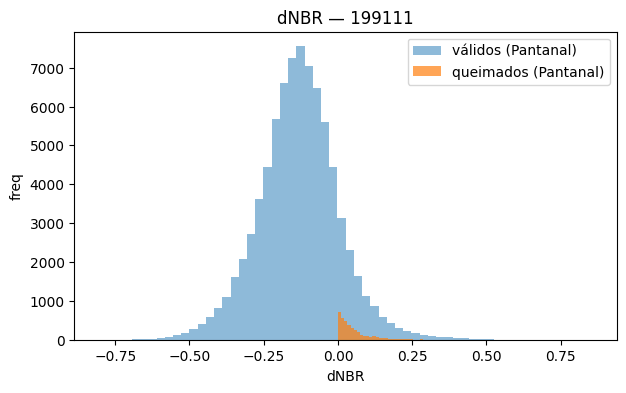

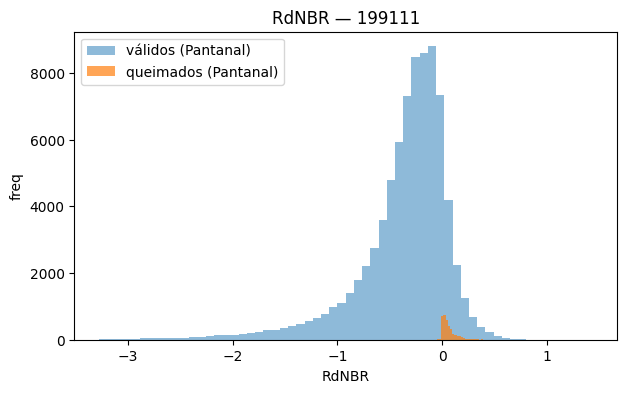

In [17]:
# @title VIZ-2b — Histogramas (dentro do shape do Pantanal)
import geopandas as gpd
from rasterio.features import rasterize
import numpy as np, rasterio as rio, matplotlib.pyplot as plt

BOUND_FP = CONFIG["boundary_path"]  # seu Pantanal.shp
#YM_EXAMPLE = df.sort_values("dnbr_p50", ascending=False)["yyyymm"].iloc[0]
YM_EXAMPLE = df.sort_values("area_burned_km2", ascending=False)["yyyymm"].iloc[0]
dn_fp  = EV_DIR / f"dnbr_{YM_EXAMPLE}.tif"
rd_fp  = EV_DIR / f"rdnbr_{YM_EXAMPLE}.tif"
ev_fp  = EV_DIR / f"events_fire_{YM_EXAMPLE}.tif"

with rio.open(ev_fp) as s_ev, rio.open(dn_fp) as s_dn, rio.open(rd_fp) as s_rd:
    ev = s_ev.read(1).astype(np.uint8)
    dn = s_dn.read(1).astype(np.float32)
    rd = s_rd.read(1).astype(np.float32)
    meta = s_ev.meta

# máscara raster do Pantanal na grade do raster
gdf = gpd.read_file(BOUND_FP)
gdf = gdf.to_crs(meta["crs"])
shapes = [(geom, 1) for geom in gdf.geometry if not geom.is_empty]
mask_pant = rasterize(
    shapes, out_shape=(meta["height"], meta["width"]),
    transform=meta["transform"], fill=0, dtype="uint8"
).astype(bool)

# aplica máscara: tudo fora do Pantanal vira NaN/0
valid = np.isfinite(dn) & mask_pant
burn  = (ev==1) & valid

# amostra para gráficos leves
N = 80000
idx_all  = np.flatnonzero(valid)
idx_burn = np.flatnonzero(burn)
rng = np.random.default_rng(0)
if idx_all.size > N:  idx_all  = rng.choice(idx_all,  N, replace=False)
if idx_burn.size > N: idx_burn = rng.choice(idx_burn, N, replace=False)

dn_all, dn_burn = dn.flat[idx_all], dn.flat[idx_burn]
rd_all, rd_burn = rd.flat[idx_all], rd.flat[idx_burn]

# dNBR
plt.figure(figsize=(7,4))
plt.hist(dn_all[~np.isnan(dn_all)], bins=60, alpha=0.5, label="válidos (Pantanal)")
plt.hist(dn_burn[~np.isnan(dn_burn)], bins=60, alpha=0.7, label="queimados (Pantanal)")
plt.title(f"dNBR — {YM_EXAMPLE}"); plt.xlabel("dNBR"); plt.ylabel("freq"); plt.legend(); plt.show()

# RdNBR
plt.figure(figsize=(7,4))
plt.hist(rd_all[~np.isnan(rd_all)], bins=60, alpha=0.5, label="válidos (Pantanal)")
plt.hist(rd_burn[~np.isnan(rd_burn)], bins=60, alpha=0.7, label="queimados (Pantanal)")
plt.title(f"RdNBR — {YM_EXAMPLE}"); plt.xlabel("RdNBR"); plt.ylabel("freq"); plt.legend(); plt.show()


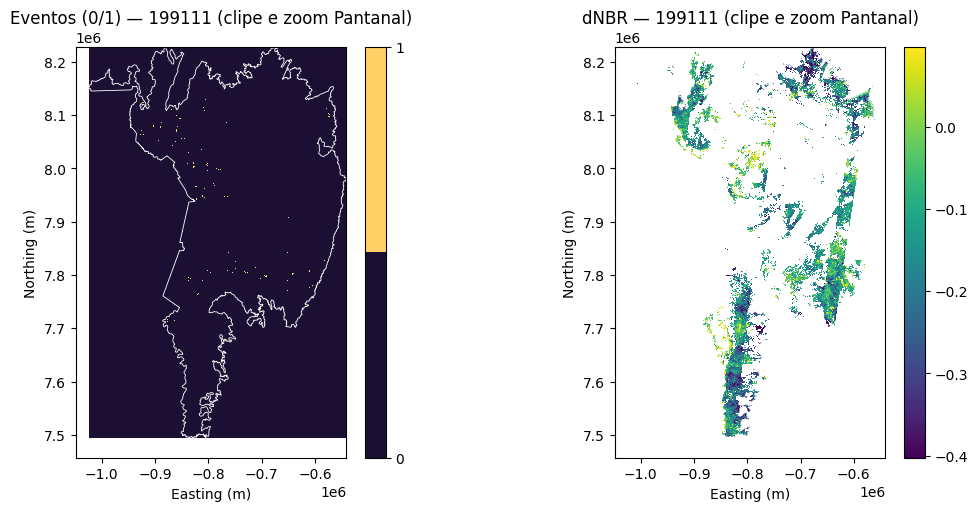

In [16]:
# @title VIZ-3c — Previews com zoom automático ao Pantanal + paleta binária
import numpy as np, matplotlib.pyplot as plt, rasterio as rio
from rasterio.enums import Resampling
from rasterio.features import rasterize
from rasterio.warp import reproject, Resampling as WarpResamp
from affine import Affine
import geopandas as gpd
from matplotlib.colors import ListedColormap

#YM_EXAMPLE = df.sort_values("dnbr_p50", ascending=False)["yyyymm"].iloc[0]
YM_EXAMPLE = df.sort_values("area_burned_km2", ascending=False)["yyyymm"].iloc[0]
ev_fp = EV_DIR / f"events_fire_{YM_EXAMPLE}.tif"
dn_fp = EV_DIR / f"dnbr_{YM_EXAMPLE}.tif"

with rio.open(ev_fp) as s_ev, rio.open(dn_fp) as s_dn:
    H, W = s_ev.height, s_ev.width
    meta = s_ev.meta.copy()
    transform = meta["transform"]
    crs = meta["crs"]

    # 1) máscara Pantanal na grade ORIGINAL
    gdf = gpd.read_file(CONFIG["boundary_path"]).to_crs(crs)
    mask_full = rasterize(
        [(g,1) for g in gdf.geometry if not g.is_empty],
        out_shape=(H, W), transform=transform, fill=0, dtype="uint8"
    ).astype(bool)

    # 2) downsample leve (<= 1500 px no lado maior)
    max_side = 1500
    scale = max(H, W) / max_side if max(H, W) > max_side else 1.0
    out_h, out_w = int(round(H/scale)), int(round(W/scale))
    new_transform = transform * Affine.scale(scale, scale)

    ev = s_ev.read(1, out_shape=(out_h, out_w), resampling=Resampling.nearest)
    dn = s_dn.read(1, out_shape=(out_h, out_w), resampling=Resampling.bilinear)

# reprojeta a máscara para a grade downsampled
mask_ds = np.zeros((out_h, out_w), dtype=np.uint8)
reproject(
    source=mask_full.astype(np.uint8),
    destination=mask_ds,
    src_transform=transform, src_crs=crs,
    dst_transform=new_transform, dst_crs=crs,
    src_nodata=0, dst_nodata=0,
    resampling=WarpResamp.nearest
)
mask_ds = mask_ds.astype(bool)

# 3) recorte automático para o bbox do Pantanal
ys, xs = np.where(mask_ds)
if ys.size == 0:
    raise RuntimeError("Máscara do Pantanal ficou vazia neste mês.")
y0, y1 = ys.min(), ys.max()+1
x0, x1 = xs.min(), xs.max()+1

ev_c  = ev[y0:y1, x0:x1]
dn_c  = dn[y0:y1, x0:x1]
msk_c = mask_ds[y0:y1, x0:x1]

# aplica o clip
ev_c  = np.where(msk_c, ev_c, 0)
dn_c  = np.where(msk_c, dn_c, np.nan)

# 4) extent em coordenadas do CRS (UTM metros)
# canto superior-esquerdo do recorte:
x_min, y_max = (new_transform * (x0, y0))
# tamanho de pixel (a,e)
px_w, px_h = new_transform.a, new_transform.e
x_max = x_min + px_w * (x1 - x0)
y_min = y_max + px_h * (y1 - y0)  # e é negativo em UTM

extent = (x_min, x_max, y_min, y_max)

# 5) plot — eventos binários
fig, ax = plt.subplots(1, 2, figsize=(11, 5), constrained_layout=True)

# paleta 0/1 discreta
cmap_ev = ListedColormap(["#1b1033", "#ffd166"])  # fundo escuro, queimado amarelo
im0 = ax[0].imshow(ev_c, origin="upper", extent=extent, interpolation="nearest",
                   vmin=0, vmax=1, cmap=cmap_ev)
ax[0].set_title(f"Eventos (0/1) — {YM_EXAMPLE} (clipe e zoom Pantanal)")
ax[0].set_aspect("equal")
cb0 = plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04); cb0.set_ticks([0,1])

# contorno do Pantanal
gdf.boundary.plot(ax=ax[0], color="white", linewidth=0.6)

# dNBR com corte robusto
if np.isfinite(dn_c).any():
    vmin = np.nanpercentile(dn_c, 2)
    vmax = np.nanpercentile(dn_c, 98)
else:
    vmin = vmax = None

im1 = ax[1].imshow(dn_c, origin="upper", extent=extent, interpolation="nearest",
                   vmin=vmin, vmax=vmax)
ax[1].set_title(f"dNBR — {YM_EXAMPLE} (clipe e zoom Pantanal)")
ax[1].set_aspect("equal")
plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

# contorno do Pantanal
gdf.boundary.plot(ax=ax[1], color="white", linewidth=0.6)

for a in ax:
    a.set_xlabel("Easting (m)"); a.set_ylabel("Northing (m)")
plt.show()




In [10]:
# @title F1-CAT — Catálogo de Eventos (Parquet particionado por mês)
%pip -q install pyarrow pandas

import glob, numpy as np, pandas as pd, rasterio as rio
from pathlib import Path

CAT_DIR = OUT_DIR / "catalogo_eventos"
CAT_DIR.mkdir(parents=True, exist_ok=True)

def pixel_xy(transform, rr, cc):
    # rr: rows (y), cc: cols (x)
    x = transform * (cc, rr)
    return x[0], x[1]

def build_catalog_for_month(ym):
    ev_fp  = EV_DIR / f"events_fire_{ym}.tif"
    dn_fp  = EV_DIR / f"dnbr_{ym}.tif"
    rd_fp  = EV_DIR / f"rdnbr_{ym}.tif"
    if not (ev_fp.exists() and dn_fp.exists() and rd_fp.exists()):
        return None

    with rio.open(ev_fp) as s_ev, rio.open(dn_fp) as s_dn, rio.open(rd_fp) as s_rd:
        ev  = s_ev.read(1)
        dn  = s_dn.read(1).astype(np.float32)
        rd  = s_rd.read(1).astype(np.float32)
        tfm = s_ev.transform
        crs = s_ev.crs

    # válidos: evento==1 e dNBR finito
    mask = (ev == 1) & np.isfinite(dn)
    if not np.any(mask):
        return None

    rr, cc = np.where(mask)
    xs, ys = pixel_xy(tfm, rr, cc)
    dn_vals = dn[rr, cc]
    rd_vals = rd[rr, cc]

    df = pd.DataFrame({
        "yyyymm": ym,
        "row": rr.astype(np.int32),
        "col": cc.astype(np.int32),
        "x": xs.astype(np.float32),
        "y": ys.astype(np.float32),
        "dnbr": dn_vals.astype(np.float32),
        "rdnbr": rd_vals.astype(np.float32),
    })
    # salva particionado por mês (facilita leitura seletiva depois)
    part_dir = CAT_DIR / f"yyyymm={ym}"
    part_dir.mkdir(parents=True, exist_ok=True)
    df.to_parquet(part_dir / "events.parquet", index=False)
    return len(df)

# roda para todos os meses disponíveis no EV_DIR
event_fps = sorted(glob.glob(str(EV_DIR / "events_fire_*.tif")))
months = [Path(fp).name.split("_")[2].split(".")[0] for fp in event_fps]
months = sorted(set(months))

tot=0
for ym in months:
    n = build_catalog_for_month(ym)
    if n:
        print(f"✔ {ym}: {n:,} pixels queimados salvos.")
        tot += n
    else:
        print(f"— {ym}: sem pixels queimados (ou faltam dnbr/rdnbr).")

print(f"\n✔ Catálogo criado em: {CAT_DIR}")
print("  Formato: partitioned parquet → yyyymm=XXXXXX/events.parquet")
print(f"  Total de linhas: {tot:,}")


✔ 198509: 19,306 pixels queimados salvos.
✔ 198603: 29,492 pixels queimados salvos.
✔ 198607: 10,269 pixels queimados salvos.
✔ 198609: 19,761 pixels queimados salvos.
✔ 198611: 1,010 pixels queimados salvos.
✔ 198701: 13,691 pixels queimados salvos.
✔ 198703: 62,214 pixels queimados salvos.
✔ 198705: 14,668 pixels queimados salvos.
✔ 198707: 12,894 pixels queimados salvos.
✔ 198709: 5,703 pixels queimados salvos.
✔ 198711: 2,195,932 pixels queimados salvos.
✔ 198801: 6,868 pixels queimados salvos.
✔ 198803: 24,375 pixels queimados salvos.
✔ 198805: 14,204 pixels queimados salvos.
✔ 198807: 11,849 pixels queimados salvos.
✔ 198809: 24,464 pixels queimados salvos.
✔ 198811: 1,204 pixels queimados salvos.
✔ 198901: 1,526 pixels queimados salvos.
✔ 198903: 36,042 pixels queimados salvos.
✔ 198905: 10,972 pixels queimados salvos.
✔ 198907: 20,889 pixels queimados salvos.
✔ 198909: 16,838 pixels queimados salvos.
— 198911: sem pixels queimados (ou faltam dnbr/rdnbr).
— 199001: sem pixels qu

In [11]:
# ler 3 meses e juntar
import pandas as pd, glob
parts = sorted(glob.glob(str(CAT_DIR / "yyyymm=*" / "events.parquet")))[:3]
amostra = pd.concat([pd.read_parquet(p) for p in parts], ignore_index=True)
amostra.head()


,yyyymm,row,col,x,y,dnbr,rdnbr
0,198509,20,1145,-681000.0,8222100.0,0.2123,0.4076
1,198509,24,1131,-685200.0,8220900.0,0.2407,0.9005
2,198509,24,1132,-684900.0,8220900.0,0.3056,0.7939
3,198509,24,1133,-684600.0,8220900.0,0.3359,0.7728
4,198509,25,471,-883200.0,8220600.0,0.2659,0.4249
